In [103]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
import csv
import pandas as pd
import sys
import os
import torch
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score
import random
import torch.optim as optim
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

def load_csv(filename):
    lines = []
    count = 0
    with open(filename) as csvfile:
        reader = csv.DictReader(csvfile)
        for line in reader:
            lines.append(line)

    return pd.DataFrame(lines)

def load_data(fn):
    return load_csv(fn)

# Note: Possibly use different data for training and validation to get a more accurate result,
# but remember that in the last part your model will be trained on the full training data
# load_adult_data() and be tested on a test dataset you don't have access to.
def load_train_data(fn):
    return load_data(fn)

def load_valid_data(fn):
    return load_data(fn)

In [105]:
# Define paths
prefix = '/content/drive/My Drive/'
customized_path = ''
sys_path = os.path.join(prefix, customized_path)
sys.path.append(sys_path)

# File path for the data
fp_data = os.path.join(sys_path, 'healthcare-dataset-stroke-data.csv')

# Load the data
data = pd.read_csv(fp_data)

# Function to preprocess the data
def preprocess_data(df):
    # Convert appropriate columns to numeric
    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df['hypertension'] = pd.to_numeric(df['hypertension'], errors='coerce')
    df['heart_disease'] = pd.to_numeric(df['heart_disease'], errors='coerce')
    df['avg_glucose_level'] = pd.to_numeric(df['avg_glucose_level'], errors='coerce')
    df['bmi'] = pd.to_numeric(df['bmi'], errors='coerce')
    df['stroke'] = pd.to_numeric(df['stroke'], errors='coerce')  # Target label

    # Drop rows with missing values in the 'bmi' column
    df = df.dropna(subset=['bmi'])
    # Encode categorical variables using LabelEncoder
    label_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
    for col in label_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))  # Ensure all data is string before encoding

    return df

# Function to split the data
def split_smart(data):
    # Separate the first 250 rows and the rest
    first_250 = data.iloc[:250]
    remaining = data.iloc[250:]

    # Shuffle the first 250 rows and split in half
    first_250_shuffled = first_250.sample(frac=1, random_state=42).reset_index(drop=True)
    first_half_250 = first_250_shuffled.iloc[:len(first_250_shuffled) // 2]
    second_half_250 = first_250_shuffled.iloc[len(first_250_shuffled) // 2:]

    # Shuffle the remaining rows and split in half
    remaining_shuffled = remaining.sample(frac=1, random_state=42).reset_index(drop=True)
    first_half_remaining = remaining_shuffled.iloc[:len(remaining_shuffled) // 2]
    second_half_remaining = remaining_shuffled.iloc[len(remaining_shuffled) // 2:]

    # Merge the first halves and second halves
    final_first_half = pd.concat([first_half_250, first_half_remaining]).reset_index(drop=True)
    final_second_half = pd.concat([second_half_250, second_half_remaining]).reset_index(drop=True)

    return final_first_half, final_second_half

# Preprocess the data
data = preprocess_data(data)

# Split the data using split_smart
train_df, valid_df = split_smart(data)
train_df = train_df.drop(columns=['id'])
valid_df = valid_df.drop(columns=['id'])
# Separate features and labels
X_train = train_df.drop(columns=['stroke'])
y_train = train_df['stroke']
X_valid = valid_df.drop(columns=['stroke'])
y_valid = valid_df['stroke']

# Standardize the features
scaler = StandardScaler()
X_train = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
X_valid = torch.tensor(scaler.transform(X_valid), dtype=torch.float32)

# Convert labels to tensors
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32).unsqueeze(1)  # Shape (N, 1)
y_valid = torch.tensor(y_valid.to_numpy(), dtype=torch.float32).unsqueeze(1)  # Shape (N, 1)

# Print the count of stroke = 1 in both halves
stroke_count_train = (train_df['stroke'] == 1).sum()
total = (train_df['stroke'] == 0).sum() + (train_df['stroke'] == 1).sum() + (valid_df['stroke'] == 1).sum() + (valid_df['stroke'] == 0).sum()
stroke_count_valid = (valid_df['stroke'] == 1).sum()
print(f"Number of stroke = 1 in training set: {stroke_count_train}")
print(f"Number of stroke = 1 in validation set: {stroke_count_valid}")
print(f"total: {total}")
# Final processed tensors
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}, y_valid shape: {y_valid.shape}")


Number of stroke = 1 in training set: 103
Number of stroke = 1 in validation set: 106
total: 4909
X_train shape: torch.Size([2454, 10]), y_train shape: torch.Size([2454, 1])
X_valid shape: torch.Size([2455, 10]), y_valid shape: torch.Size([2455, 1])


<ipython-input-105-b9d5647e30df>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.fit_transform(df[col].astype(str))  # Ensure all data is string before encoding
<ipython-input-105-b9d5647e30df>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.fit_transform(df[col].astype(str))  # Ensure all data is string before encoding
<ipython-input-105-b9d5647e30df>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [106]:
print("Total rows:", len(train_df))
print("row data:\n", train_df.iloc[0])
print("Number of columns:", len(train_df.iloc[1]))
print("Column names:", train_df.columns)


Total rows: 2454
row data:
 gender                0.00
age                  80.00
hypertension          1.00
heart_disease         0.00
ever_married          1.00
work_type             3.00
Residence_type        0.00
avg_glucose_level    91.02
bmi                  32.90
smoking_status        1.00
stroke                1.00
Name: 0, dtype: float64
Number of columns: 11
Column names: Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')


In [107]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=10, hidden_layers=[256, 128, 64, 32], output_size=1):
        super(NeuralNetwork, self).__init__()

        layers = []
        in_features = input_size
        for hidden_units in hidden_layers:
            layers.append(nn.Linear(in_features, hidden_units))
            layers.append(nn.BatchNorm1d(hidden_units))  # Batch normalization
            layers.append(nn.LeakyReLU(negative_slope=0.01))  # Leaky ReLU
            layers.append(nn.Dropout(p=0.3))  # Reduced dropout
            in_features = hidden_units

        layers.append(nn.Linear(in_features, output_size))  # Output layer
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)  # Raw logits

model = NeuralNetwork()



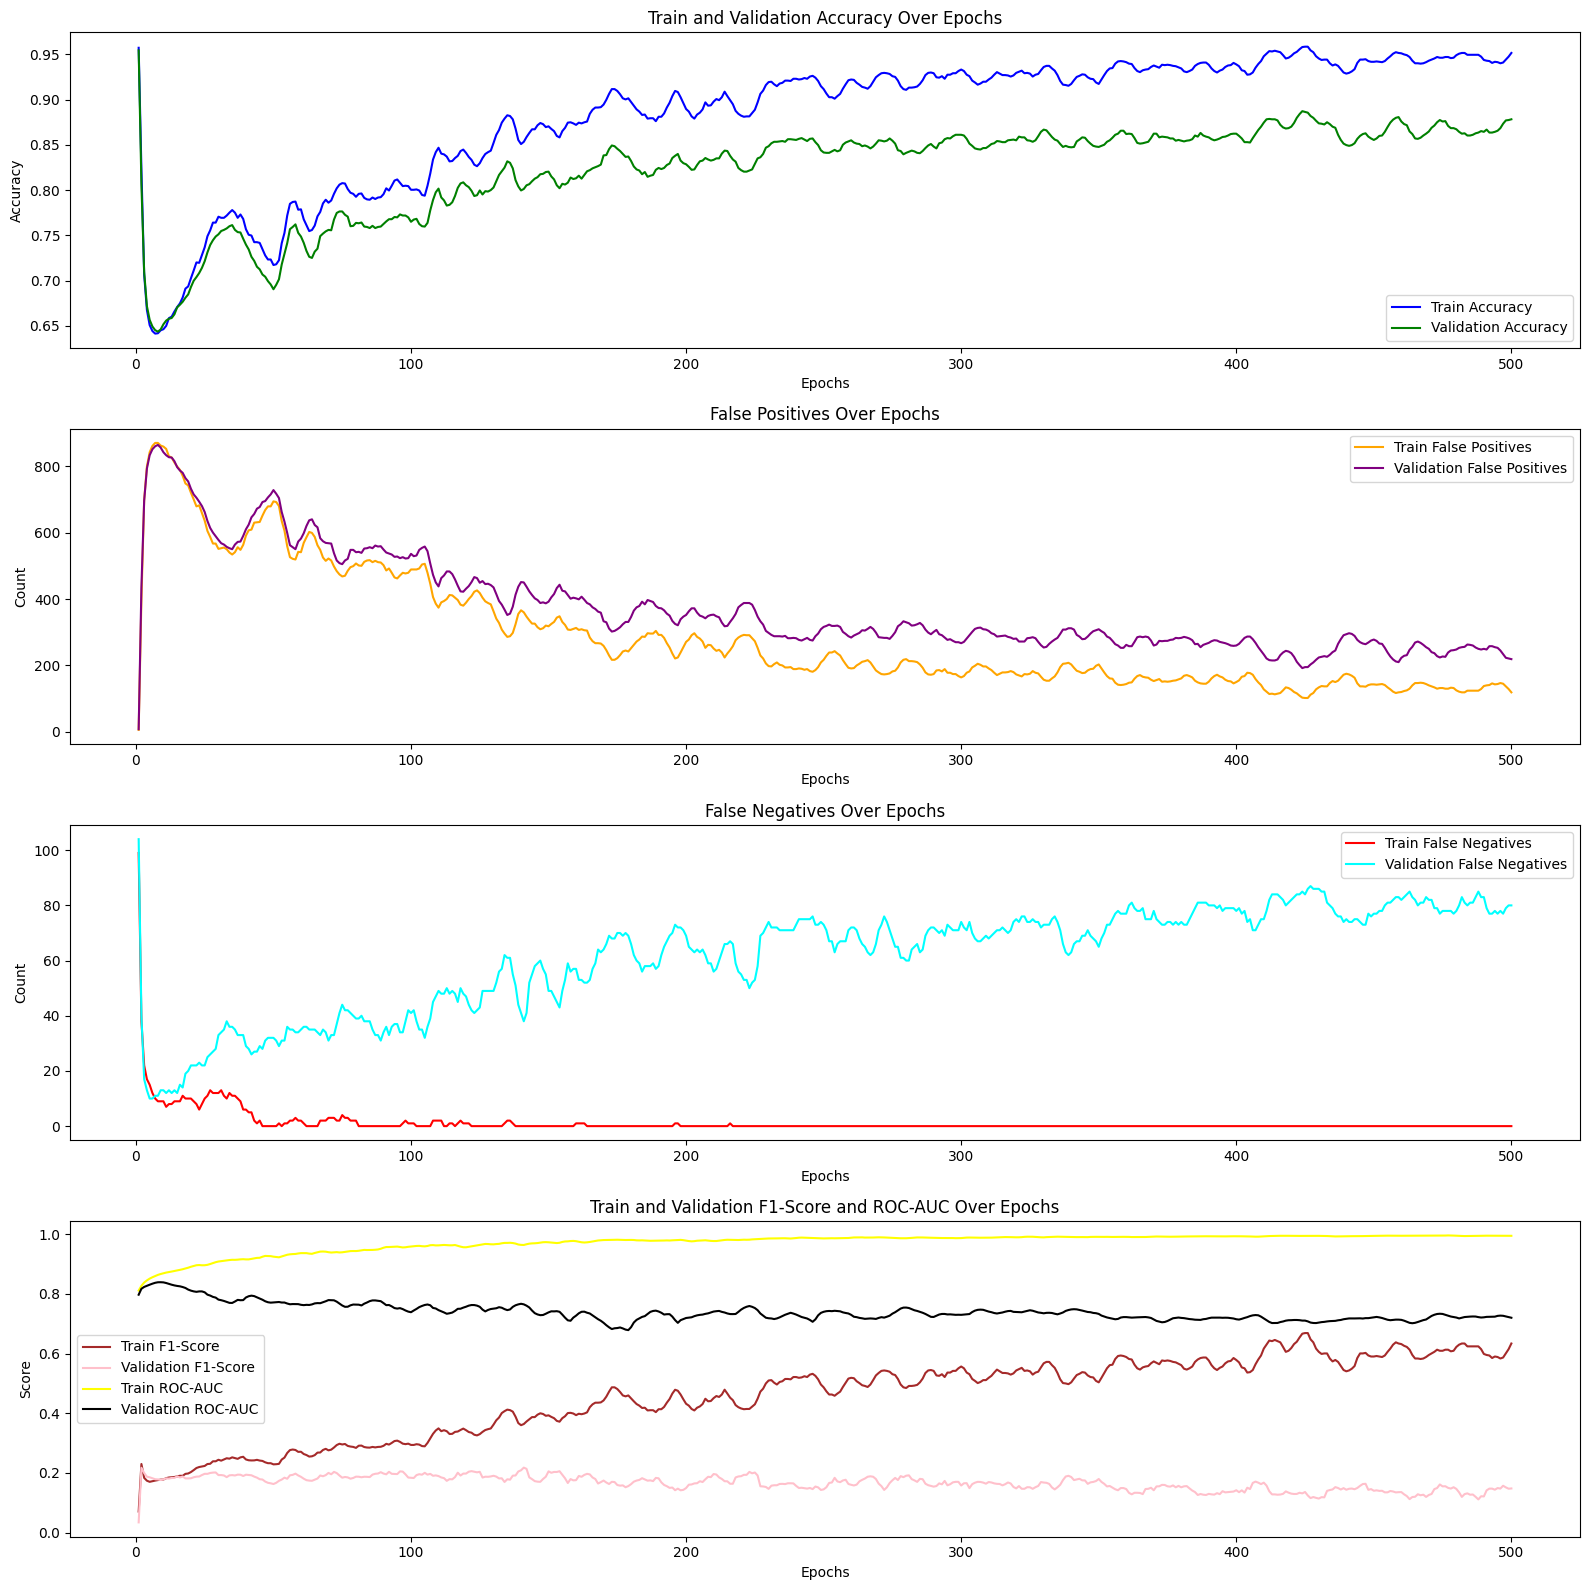

In [108]:
# Assuming class imbalance
positive_count = 209  # Number of positive samples
negative_count = 4700  # Number of negative samples

# Define the criterion with class weights
pos_weight = torch.tensor([negative_count / positive_count], dtype=torch.float32)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Adjust for class imbalance
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)  # Adjust learning rate as needed

# Number of epochs
epochs = 500

# Lists to store metrics for plotting
epoch_list = []
accuracy_list = []
false_positive_list_train = []
false_negative_list_train = []
valid_accuracy_list = []
false_positive_list_valid = []
false_negative_list_valid = []
train_f1_list = []
valid_f1_list = []
train_auc_list = []
valid_auc_list = []

for epoch in range(epochs):
    model.train()  # Set the model to training mode

    # Forward pass: compute the model's predictions and calculate the loss
    outputs = model(X_train)  # Raw logits
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()  # Clear previous gradients
    loss.backward()        # Backpropagate the loss
    optimizer.step()       # Update weights based on the gradients

    if True:
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            # Evaluate on training set
            train_logits = model(X_train)  # Raw logits
            train_probabilities = torch.sigmoid(train_logits).cpu().numpy()  # Convert to probabilities
            train_predicted_classes = (train_probabilities >= 0.5).astype(int)
            y_train_np = y_train.cpu().numpy()

            train_accuracy = (train_predicted_classes == y_train_np).mean()
            train_false_positives = ((train_predicted_classes == 1) & (y_train_np == 0)).sum()
            train_false_negatives = ((train_predicted_classes == 0) & (y_train_np == 1)).sum()
            train_f1 = f1_score(y_train_np, train_predicted_classes)
            train_auc = roc_auc_score(y_train_np, train_probabilities)

            # Evaluate on validation set
            valid_logits = model(X_valid)  # Raw logits
            valid_probabilities = torch.sigmoid(valid_logits).cpu().numpy()  # Convert to probabilities
            valid_predicted_classes = (valid_probabilities >= 0.5).astype(int)
            y_valid_np = y_valid.cpu().numpy()

            valid_accuracy = (valid_predicted_classes == y_valid_np).mean()
            valid_false_positives = ((valid_predicted_classes == 1) & (y_valid_np == 0)).sum()
            valid_false_negatives = ((valid_predicted_classes == 0) & (y_valid_np == 1)).sum()
            valid_f1 = f1_score(y_valid_np, valid_predicted_classes)
            valid_auc = roc_auc_score(y_valid_np, valid_probabilities)

        # Store metrics for plotting
        epoch_list.append(epoch + 1)
        accuracy_list.append(train_accuracy)
        false_positive_list_train.append(train_false_positives)
        false_negative_list_train.append(train_false_negatives)
        valid_accuracy_list.append(valid_accuracy)
        false_positive_list_valid.append(valid_false_positives)
        false_negative_list_valid.append(valid_false_negatives)
        train_f1_list.append(train_f1)
        valid_f1_list.append(valid_f1)
        train_auc_list.append(train_auc)
        valid_auc_list.append(valid_auc)

        # Print metrics
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, "
              f"Train Accuracy: {train_accuracy * 100:.2f}%, Valid Accuracy: {valid_accuracy * 100:.2f}%, "
              f"Train FP: {train_false_positives}, Train FN: {train_false_negatives}, "
              f"Valid FP: {valid_false_positives}, Valid FN: {valid_false_negatives}, "
              f"Train F1: {train_f1:.4f}, Valid F1: {valid_f1:.4f}, "
              f"Train AUC: {train_auc:.4f}, Valid AUC: {valid_auc:.4f}")

# Plotting the metrics
plt.figure(figsize=(16, 16))

# Training and Validation Accuracy plot
plt.subplot(4, 1, 1)
plt.plot(epoch_list, accuracy_list, label="Train Accuracy", color="blue")
plt.plot(epoch_list, valid_accuracy_list, label="Validation Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy Over Epochs")
plt.legend()

# False Positives plot
plt.subplot(4, 1, 2)
plt.plot(epoch_list, false_positive_list_train, label="Train False Positives", color="orange")
plt.plot(epoch_list, false_positive_list_valid, label="Validation False Positives", color="purple")
plt.xlabel("Epochs")
plt.ylabel("Count")
plt.title("False Positives Over Epochs")
plt.legend()

# False Negatives plot
plt.subplot(4, 1, 3)
plt.plot(epoch_list, false_negative_list_train, label="Train False Negatives", color="red")
plt.plot(epoch_list, false_negative_list_valid, label="Validation False Negatives", color="cyan")
plt.xlabel("Epochs")
plt.ylabel("Count")
plt.title("False Negatives Over Epochs")
plt.legend()

# F1-Score and ROC-AUC plot
plt.subplot(4, 1, 4)
plt.plot(epoch_list, train_f1_list, label="Train F1-Score", color="brown")
plt.plot(epoch_list, valid_f1_list, label="Validation F1-Score", color="pink")
plt.plot(epoch_list, train_auc_list, label="Train ROC-AUC", color="yellow")
plt.plot(epoch_list, valid_auc_list, label="Validation ROC-AUC", color="black")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Train and Validation F1-Score and ROC-AUC Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


In [109]:
# Combine training and validation sets
X_combined = torch.cat([X_train, X_valid], dim=0)
y_combined = torch.cat([y_train, y_valid], dim=0)

# Get ground truth labels
y_combined_np = y_combined.cpu().numpy().flatten()

# Make predictions
model.eval()
with torch.no_grad():
    logits = model(X_combined)
    probabilities = torch.sigmoid(logits).cpu().numpy().flatten()
    predicted_classes = (probabilities >= 0.5).astype(int)

# Ensure predictions and ground truth labels are 1D arrays
predicted_classes = predicted_classes.flatten() if len(predicted_classes.shape) > 1 else predicted_classes
y_combined_np = y_combined_np.flatten() if len(y_combined_np.shape) > 1 else y_combined_np

# Calculate metrics
accuracy = (predicted_classes == y_combined_np).mean()
false_positives = int(((predicted_classes == 1) & (y_combined_np == 0)).sum())
false_negatives = int(((predicted_classes == 0) & (y_combined_np == 1)).sum())
f1 = f1_score(y_combined_np, predicted_classes)
auc = roc_auc_score(y_combined_np, probabilities)

# Print the final metrics
print("Final Model Performance on the Whole Dataset:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {auc:.4f}")
print(f"False Positives: {false_positives}")
print(f"False Negatives: {false_negatives}")


Final Model Performance on the Whole Dataset:
Accuracy: 91.49%
F1-Score: 0.3817
ROC-AUC: 0.8603
False Positives: 338
False Negatives: 80
